<a href="https://colab.research.google.com/github/AjinJayan/AJ/blob/master/transfer_learning_dog_cat_%40.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip -q "/content/drive/My Drive/train.zip"

In [0]:
import glob
import numpy as np
import os
import shutil
import pandas as pd
import time as t
np.random.seed(42)

In [17]:
files = glob.glob('train/*')

cat_files = [fn for fn in files if 'cat' in fn]
dog_files = [fn for fn in files if 'dog' in fn]
len(cat_files), len(dog_files)

(2503, 2504)

In [18]:
cat_train = np.random.choice(cat_files, size=1500, replace=False)
dog_train = np.random.choice(dog_files, size=1500, replace=False)
cat_files = list(set(cat_files) - set(cat_train))
dog_files = list(set(dog_files) - set(dog_train))

cat_val = np.random.choice(cat_files, size=500, replace=False)
dog_val = np.random.choice(dog_files, size=500, replace=False)
cat_files = list(set(cat_files) - set(cat_val))
dog_files = list(set(dog_files) - set(dog_val))

cat_test = np.random.choice(cat_files, size=500, replace=False)
dog_test = np.random.choice(dog_files, size=500, replace=False)

print('Cat datasets:', cat_train.shape, cat_val.shape, cat_test.shape)
print('Dog datasets:', dog_train.shape, dog_val.shape, dog_test.shape)

Cat datasets: (1500,) (500,) (500,)
Dog datasets: (1500,) (500,) (500,)


In [0]:
train_dir = 'training_data'
val_dir = 'validation_data'
test_dir = 'test_data'

train_files = np.concatenate([cat_train, dog_train])
validate_files = np.concatenate([cat_val, dog_val])
test_files = np.concatenate([cat_test, dog_test])

os.mkdir(train_dir) if not os.path.isdir(train_dir) else None
os.mkdir(val_dir) if not os.path.isdir(val_dir) else None
os.mkdir(test_dir) if not os.path.isdir(test_dir) else None

for fn in train_files:
    shutil.copy(fn, train_dir)

for fn in validate_files:
    shutil.copy(fn, val_dir)
    
for fn in test_files:
    shutil.copy(fn, test_dir)

In [0]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
%matplotlib inline

In [21]:
IMG_DIM = (150, 150)

train_files = glob.glob('training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[1].split('.')[0].strip() for fn in train_files]

validation_files = glob.glob('validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('/')[1].split('.')[0].strip() for fn in validation_files]

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (3000, 150, 150, 3) 	Validation dataset shape: (1000, 150, 150, 3)


(150, 150, 3)


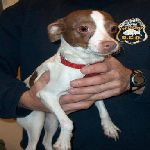

In [22]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

print(train_imgs[0].shape)
array_to_img(train_imgs[0])

In [23]:
batch_size = 30
num_classes = 2
epochs = 30
input_shape = (150, 150, 3)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[1495:1505], train_labels_enc[1495:1505])

['cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat', 'dog', 'cat', 'dog'] [0 0 0 1 1 1 0 1 0 1]


In [24]:
import tensorflow as tf
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model
from tensorflow import keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = True

set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])  

58892288/58889256 [==============================] - 0s 0us/step


,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.In...,input_1,False
1,<tensorflow.python.keras.layers.convolutional....,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional....,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPoo...,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional....,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional....,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPoo...,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional....,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional....,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional....,block3_conv3,False


(1, 4, 4, 512)


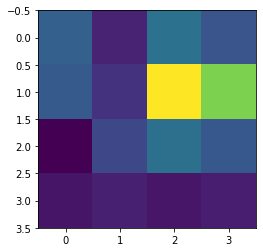

In [25]:
bottleneck_feature_example = vgg.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:,:,0])

In [26]:
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features
    
train_features_vgg = get_bottleneck_features(vgg_model, train_imgs_scaled)
validation_features_vgg = get_bottleneck_features(vgg_model, validation_imgs_scaled)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape)

Train Bottleneck Features: (3000, 8192) 	Validation Bottleneck Features: (1000, 8192)


In [0]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)


Labels: ['cat', 'cat', 'cat', 'cat', 'cat']


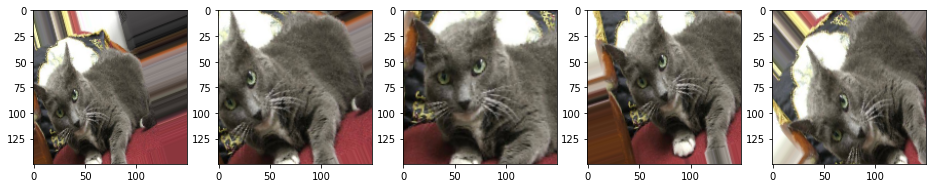

In [28]:
img_id = 2594
cat_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
cat = [next(cat_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in cat])
l = [ax[i].imshow(cat[i][0][0]) for i in range(0,5)]

In [29]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])
model.summary()              

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 8192)              14714688  
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 19,172,673
Trainable params: 17,437,185
Non-trainable params: 1,735,488
__________________________________

In [30]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100,
                              validation_data=val_generator, validation_steps=50, 
                              verbose=1) 

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
100/100 [==============================] - 18s 183ms/step - loss: 0.5680 - accuracy: 0.6920 - val_loss: 0.3014 - val_accuracy: 0.8750
Epoch 2/100
100/100 [==============================] - 18s 177ms/step - loss: 0.4093 - accuracy: 0.8113 - val_loss: 0.2300 - val_accuracy: 0.9040
Epoch 3/100
100/100 [==============================] - 18s 177ms/step - loss: 0.3163 - accuracy: 0.8657 - val_loss: 0.1889 - val_accuracy: 0.9240
Epoch 4/100
100/100 [==============================] - 18s 178ms/step - loss: 0.2802 - accuracy: 0.8810 - val_loss: 0.1896 - val_accuracy: 0.9180
Epoch 5/100
100/100 [==============================] - 18s 177ms/step - loss: 0.2651 - accuracy: 0.8883 - val_loss: 0.1456 - val_accuracy: 0.9410
Epoch 6/100
100/100 [==============================] - 18s 176ms/step - loss: 0.2275 - accuracy: 0.9073 - val_loss: 0.1479 - val_accuracy: 0.9500
Epoch 7/100
100/100 [===========================

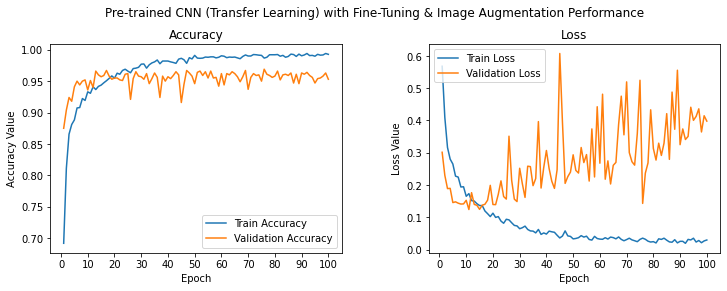

In [31]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) with Fine-Tuning & Image Augmentation Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,101))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 10))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 101, 10))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
from tensorflow.keras.models import load_model

model.save('cats_dogs_tlearn_finetune_img_aug_cnn.h5')

num2class_label_transformer = lambda l: ['cat' if x == 0 else 'dog' for x in l]
class2num_label_transformer = lambda l: [0 if x == 'cat' else 1 for x in l]

In [33]:
tl_img_aug_finetune_cnn = load_model('cats_dogs_tlearn_finetune_img_aug_cnn.h5')

In [34]:
IMG_DIM = (150, 150)

test_files = glob.glob('test_data/*')
test_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [fn.split('/')[1].split('.')[0].strip() for fn in test_files]

test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255
test_labels_enc = class2num_label_transformer(test_labels)

print('Test dataset shape:', test_imgs.shape)
print(test_labels[0:5], test_labels_enc[0:5])

Test dataset shape: (1000, 150, 150, 3)
['dog', 'cat', 'cat', 'cat', 'dog'] [1, 0, 0, 0, 1]


In [0]:
 from model_evaluation_utils import display_model_performance_metrics

In [0]:
import time as t

In [41]:
A1=t.time()
predictions = tl_img_aug_finetune_cnn.predict_classes(test_imgs_scaled, verbose=0)
A2=t.time()
print((A2-A1)/1000)

0.0012309925556182862


In [42]:
predictions = num2class_label_transformer(predictions)
display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.96
Precision: 0.9611
Recall: 0.96
F1 Score: 0.96

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         dog       0.94      0.98      0.96       500
         cat       0.98      0.94      0.96       500

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000


Prediction Confusion Matrix:
------------------------------
            Predicted:     
                   dog  cat
Actual: dog        492    8
        cat         32  468


/content/model_evaluation_utils.py:63: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels),
/content/model_evaluation_utils.py:65: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels))
